1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

2. Loading and Understanding the Dataset

In [2]:
pip install kaggle

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.17G/5.20G [00:45<00:00, 79.0MB/s]
100% 5.20G/5.20G [00:45<00:00, 124MB/s] 


In [4]:
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [5]:
import subprocess

# Buat folder baru
subprocess.run(["mkdir", "/content/skin-cancer-mnist-ham10000"])

# Pindahkan dua folder ke dalam folder baru
subprocess.run(["mv", "/content/HAM10000_images_part_1", "/content/skin-cancer-mnist-ham10000/"])
subprocess.run(["mv", "/content/HAM10000_images_part_2", "/content/skin-cancer-mnist-ham10000/"])

CompletedProcess(args=['mv', '/content/HAM10000_images_part_2', '/content/skin-cancer-mnist-ham10000/'], returncode=0)

In [6]:
# Setting data directory
data_directory = os.path.join("/content/")
os.listdir(data_directory)# Loading HAM10000_meatdata.csv
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

3. Creating a Dictionary for Image Path and Lesion Type

In [7]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((150,150))));
data.sample(5)

lesion_id      image_id     dx    dx_type   age   sex localization  \
9482  HAM_0002876  ISIC_0034098     nv  consensus  25.0  male      abdomen   
9874  HAM_0005480  ISIC_0025992  akiec      histo  65.0  male         face   
1440  HAM_0005328  ISIC_0028969    mel      histo  75.0  male      abdomen   
5739  HAM_0001768  ISIC_0026019     nv  follow_up  30.0  male         back   
123   HAM_0004332  ISIC_0032534    bkl      histo  55.0  male        trunk   

                                cell_type  \
9482                Melanocytic nevi (nv)   
9874            Actinic keratoses (akiec)   
1440                       Melanoma (mel)   
5739                Melanocytic nevi (nv)   
123   Benign keratosis-like lesions (bkl)   

                                                  path  \
9482  /content/ham10000_images_part_2/ISIC_0034098.jpg   
9874  /content/ham10000_images_part_1/ISIC_0025992.jpg   
1440  /content/ham10000_images_part_1/ISIC_0028969.jpg   
5739  /content/ham10000_images_part_1/ISIC_0026019.jpg   
123   /content/ham10000_images_part_2/ISIC_0032534.jpg   

                                            image_pixel  
9482  [[[219, 221, 223], [216, 215, 219], [213, 212,...  
9874  [[[208, 155, 141], [207, 150, 136], [209, 145,...  
1440  [[[200, 169, 175], [200, 169, 175], [202, 171,...  
5739  [[[248, 179, 190], [248, 179, 189], [248, 178,...  
123   [[[39, 38, 45], [45, 46, 54], [58, 59, 66], [6...

4. Exploratory Data Analysis (EDA)

In [8]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index,
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index,
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

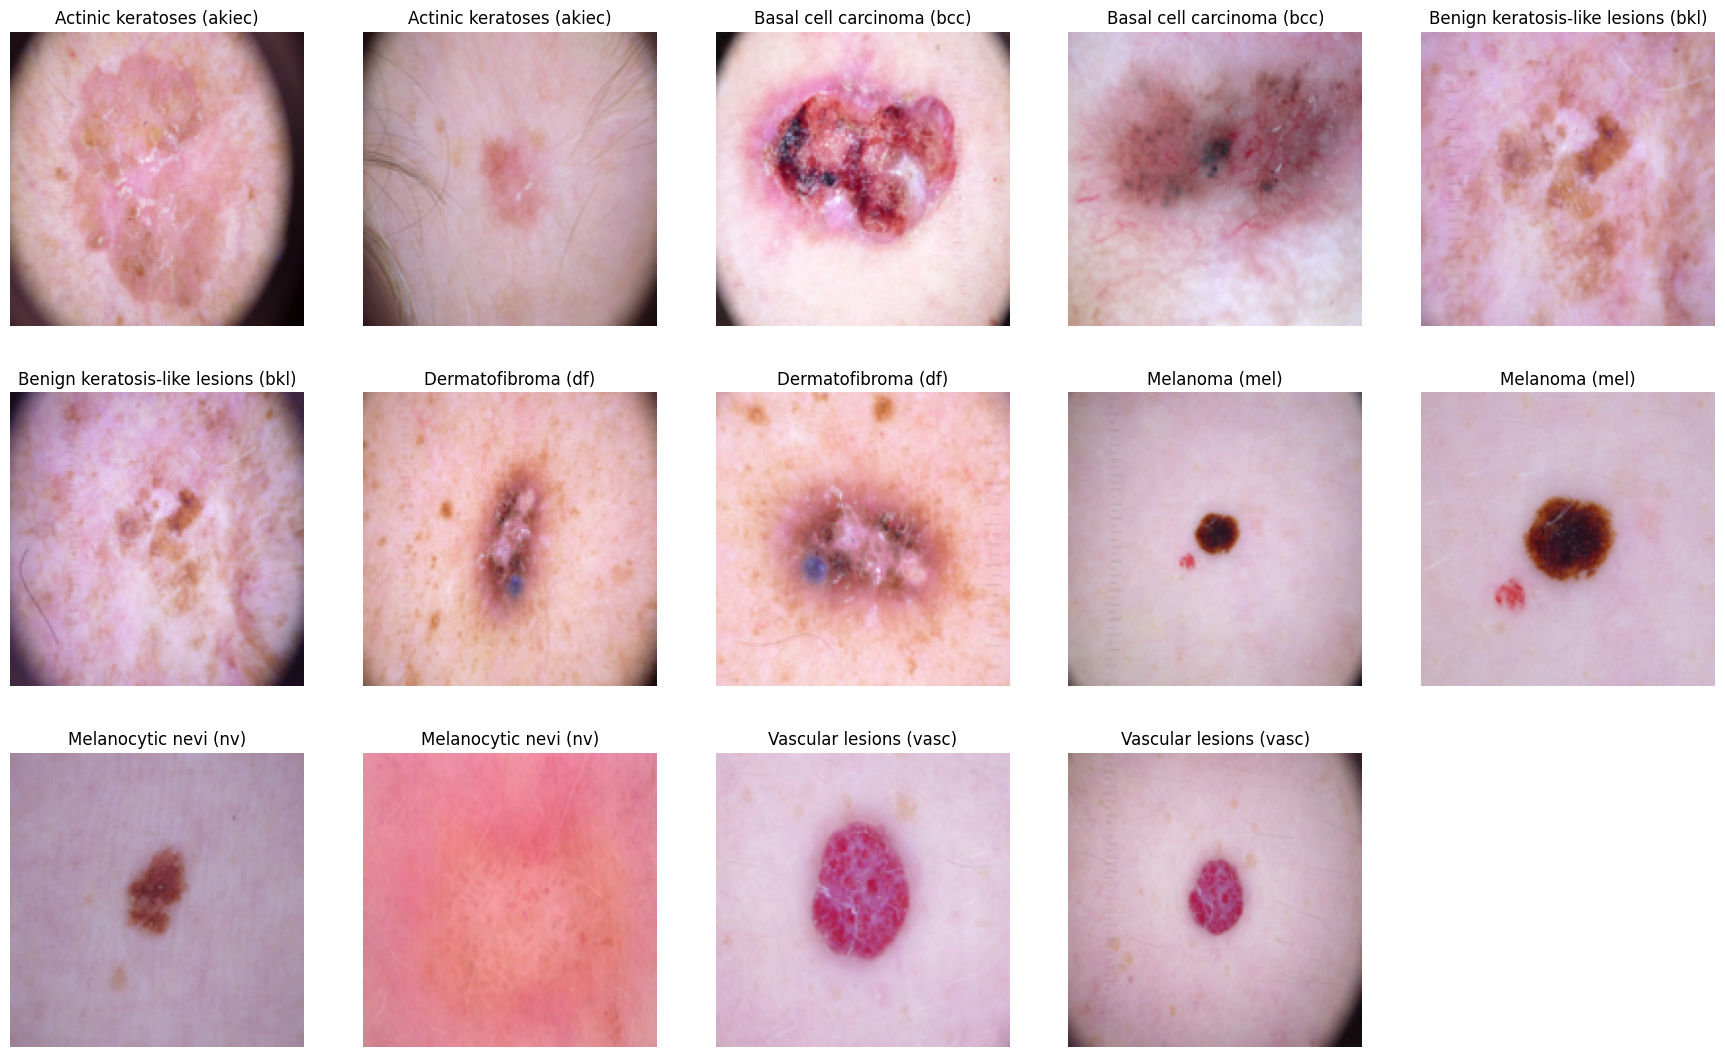

In [9]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

5. Prepocessing

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [11]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [12]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')# Categorically encoding label of the images
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

lesion_id      image_id   dx    dx_type  age     sex     localization  \
9442  HAM_0005313  ISIC_0033335   nv  consensus   20    male             back   
9497  HAM_0003968  ISIC_0033161   nv  consensus   35  female             back   
9636  HAM_0004370  ISIC_0024757   nv  consensus   10    male          unknown   
942   HAM_0000080  ISIC_0033528  bkl  consensus   70    male  lower extremity   
1162  HAM_0006188  ISIC_0027188   df  consensus   40    male  lower extremity   

                                cell_type  \
9442                Melanocytic nevi (nv)   
9497                Melanocytic nevi (nv)   
9636                Melanocytic nevi (nv)   
942   Benign keratosis-like lesions (bkl)   
1162                  Dermatofibroma (df)   

                                                  path  \
9442  /content/ham10000_images_part_2/ISIC_0033335.jpg   
9497  /content/ham10000_images_part_2/ISIC_0033161.jpg   
9636  /content/ham10000_images_part_1/ISIC_0024757.jpg   
942   /content/ham10000_images_part_2/ISIC_0033528.jpg   
1162  /content/ham10000_images_part_1/ISIC_0027188.jpg   

                                            image_pixel  label  
9442  [[[26, 15, 23], [33, 20, 30], [41, 26, 38], [5...      0  
9497  [[[166, 134, 158], [167, 134, 158], [165, 132,...      0  
9636  [[[212, 179, 210], [213, 179, 210], [213, 180,...      0  
942   [[[29, 16, 21], [32, 19, 26], [34, 22, 31], [3...      2  
1162  [[[45, 36, 46], [62, 50, 61], [78, 64, 77], [8...      6

6. Data ORIGINAL

In [13]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 150, 150, 3)
(10015, 1)


7. Model Creation, Training, and Testing

In [17]:
# Splitting into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_orig, Y_orig, test_size=0.2, random_state=1)


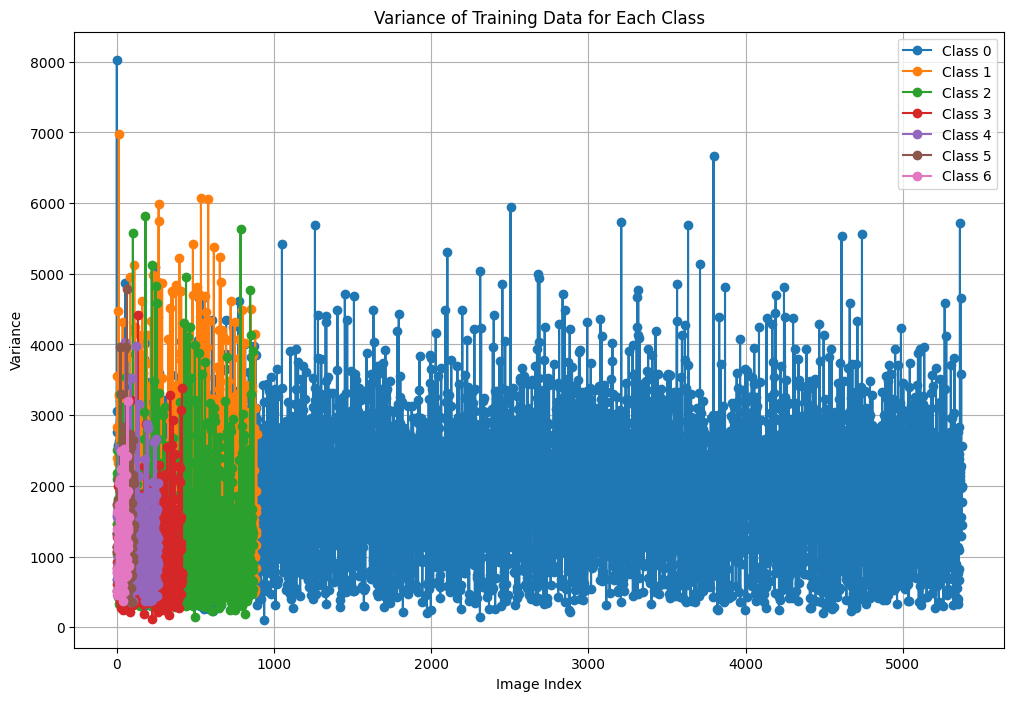

In [34]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Function to calculate variance for each class
def calculate_variance(X_train, Y_train, label):
    class_indices = np.where(Y_train == label)[0]
    class_data = [X_train[i] for i in class_indices]
    variances = [np.var(img) for img in class_data]
    return variances

# Calculate variance for each class
variance_dict = {label: calculate_variance(X_train, Y_train, label) for label in np.unique(Y_train)}

import matplotlib.pyplot as plt

# Plot untuk variansi setiap kelas
plt.figure(figsize=(12, 8))

for label, variances in variance_dict.items():
    plt.plot(np.arange(len(variances)), variances, marker='o', label=f'Class {label}')

plt.xlabel('Image Index')
plt.ylabel('Variance')
plt.title('Variance of Training Data for Each Class')
plt.legend()
plt.grid(True)

plt.show()


In [19]:
# Create the model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(150, 150, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optimizer,
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 38, 38, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 19, 19, 64)       

In [21]:

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                       mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                          verbose=1, mode='auto')

In [22]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size=64,
                    epochs=25,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/25
101/101 [==============================] - 7s 17ms/step - loss: 4.0059 - accuracy: 0.6433 - val_loss: 0.9263 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 2/25
101/101 [==============================] - 1s 9ms/step - loss: 0.9080 - accuracy: 0.6775 - val_loss: 0.8727 - val_accuracy: 0.6825 - lr: 0.0010
Epoch 3/25
101/101 [==============================] - 1s 9ms/step - loss: 0.8752 - accuracy: 0.6890 - val_loss: 0.8684 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 4/25
101/101 [==============================] - 1s 9ms/step - loss: 0.8499 - accuracy: 0.6915 - val_loss: 0.9039 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 5/25
101/101 [==============================] - 1s 8ms/step - loss: 0.8092 - accuracy: 0.7092 - val_loss: 0.8763 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 6/25
101/101 [==============================] - 1s 9ms/step - loss: 0.7674 - accuracy: 0.7226 - val_loss: 0.8238 - val_accuracy: 0.7099 - lr: 0.0010
Epoch 7/25
101/101 [==============================] - 1s 9ms/step - l

In [24]:
# Plot the model training curve
fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
fig.add_trace(
    go.Scatter(
        y=history.history['accuracy'],
        name='train_acc'),
    row=1, col=1)
fig.add_trace(
    go.Scatter(
        y=history.history['val_accuracy'],
        name='val_acc'),
    row=1, col=1)
fig.add_trace(
    go.Scatter(
        y=history.history['loss'],
        name='train_loss'),
    row=1, col=2)
fig.add_trace(
    go.Scatter(
        y=history.history['val_loss'],
        name='val_loss'),
    row=1, col=2)
fig.show()


In [23]:

# Test the model
model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))
y_true = np.array(Y_test)
y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
print(clr)

Test Accuracy: 71.842%
63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

          nv       0.80      0.94      0.86      1327
         mel       0.50      0.27      0.35       222
         bkl       0.39      0.29      0.34       228
         bcc       0.41      0.45      0.43        96
       akiec       0.40      0.07      0.11        61
        vasc       0.60      0.56      0.58        32
          df       1.00      0.03      0.05        37

    accuracy                           0.72      2003
   macro avg       0.58      0.37      0.39      2003
weighted avg       0.69      0.72      0.68      2003



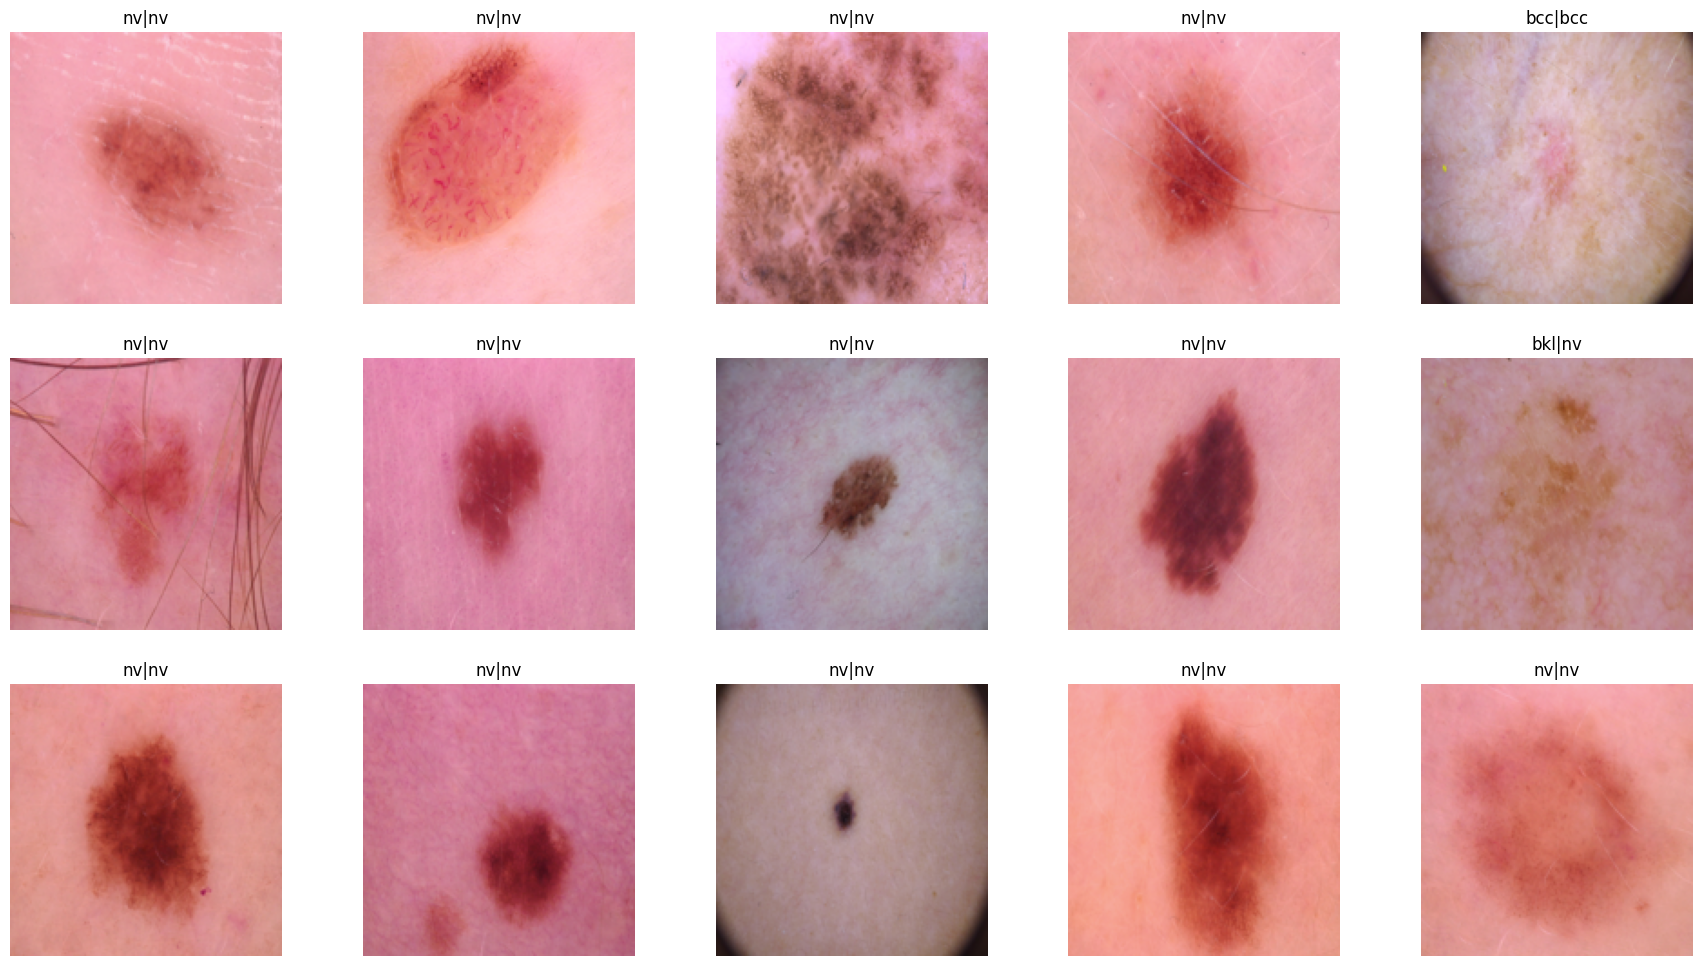

In [25]:
sample_data = X_test[:15]
plt.figure(figsize=(22, 12))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(sample_data[i])
    plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
    plt.axis("off")
plt.show()

63/63 [==============================] - 0s 3ms/step


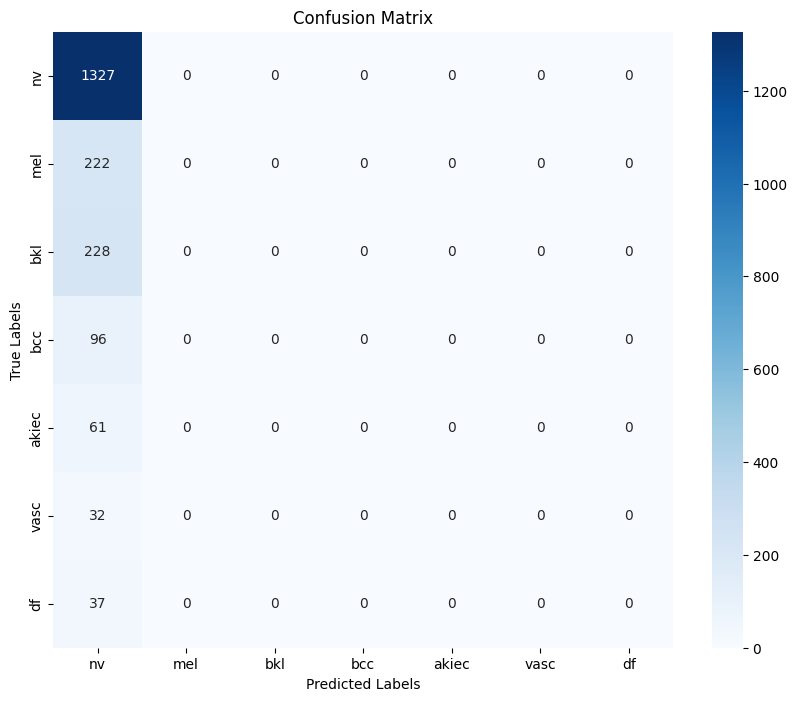

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Melakukan prediksi terhadap data uji
y_pred_orig = model.predict(X_test)
y_pred_orig = np.argmax(Y_test, axis=1)

# Membuat confusion matrix
cm = confusion_matrix(Y_test, y_pred_orig)

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Saving ISIC_0024516.jpg to ISIC_0024516.jpg


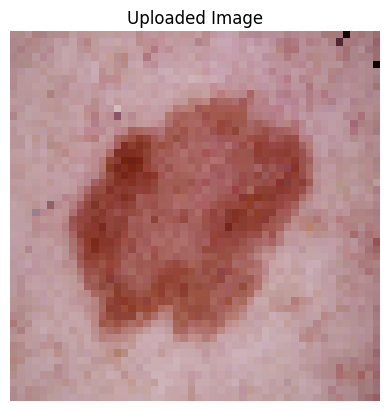

1/1 [==============================] - 0s 23ms/step
Predicted class: Benign keratosis-like lesions (bkl)


In [ ]:
from keras.preprocessing import image
from google.colab import files
#10. New Data Prediction
def predict_new_image(model):
    # Upload new image
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load and preprocess the image
        path = fn
        img = image.load_img(path, target_size=(50, 50))
        imgplot = plt.imshow(img)
        plt.title("Uploaded Image")
        plt.axis("off")
        plt.show()

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0  # Normalize the image as the training data was normalized

        # Predict the class
        pred = model.predict(x)
        predicted_class = np.argmax(pred, axis=1)

        # Map the predicted label to the lesion type
        lesion_type = label_mapping[predicted_class[0]]
        lesion_name = lesion_type_dict[lesion_type]

        print(f"Predicted class: {lesion_name}")

# Call the function to predict new image
predict_new_image(model2)